# Point-A Reference Plan Optimization (v0.3)

This notebook revisits the previous `point_a_plan` workflow and adds a cvxpy-based dwell-time optimizer.
Tandem reference points are enforced at 100% of the prescription, while ovoid reference points are held at 140%.
The steps below load the brachy plan, assemble TG-43 influence matrices at the reference points, and solve a convex program that minimally perturbs the plan dwell times while satisfying the dose-rate requirements.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp

from pathlib import Path
from typing import Any, Dict, Iterable, List, Tuple

try:
    from IPython.display import display
except ImportError:  # pragma: no cover - fallback when running as a script
    def display(obj):
        print(obj)

from omegaconf import DictConfig, OmegaConf

import tg43.dicom_helper as dhelp
import tg43.dose_calculation as dosecal
import src.dataloader as dataloader

In [17]:
def load_hyperparams(config_path: Path) -> DictConfig:
    """Load run-time hyperparameters from YAML."""
    cfg = OmegaConf.load(config_path)
    return cfg


def resolve_single(path_iterable: Iterable[Path], description: str) -> Path:
    """Return the first existing path from ``path_iterable``."""
    candidates = sorted(path_iterable)
    if not candidates:
        raise FileNotFoundError(f"No files found for {description}.")
    return candidates[0]


def load_case_paths(root: Path, case_id: Path) -> Dict[str, Path]:
    """Collect CT/RTDICOM paths for a given case identifier."""
    case_dir = root / f"{case_id}"
    if not case_dir.exists():
        raise FileNotFoundError(f"Case directory not found: {case_dir}")

    return {
        "ct": resolve_single(case_dir.glob("CT*/*"), "CT series"),
        "dose": resolve_single(case_dir.glob("RTDOSE*/*/*.dcm"), "RTDOSE file"),
        "plan": resolve_single(case_dir.glob("RTPLAN*/*/*.dcm"), "RTPLAN file"),
        "struct": resolve_single(case_dir.glob("RTSTRUCT*/*/*.dcm"), "RTSTRUCT file"),
    }

In [18]:
def get_reference_point(aux_points: Dict[str, Any], label: str) -> Dict[str, Any]:
    for entry in aux_points.get("dose_reference_points", []):
        if entry["description"].strip().lower() == label.lower():
            return entry
    raise ValueError(f"{label} reference point not found in RTPLAN.")


def filter_redundant_positions(positions: Iterable[np.ndarray]) -> np.ndarray:
    seen = set()
    unique = []
    for pos in positions:
        if pos is None:
            continue
        arr = np.asarray(pos, dtype=float)
        key = tuple(arr.tolist())
        if key in seen:
            continue
        seen.add(key)
        unique.append(arr)
    if not unique:
        return np.zeros((0, 3), dtype=float)
    return np.vstack(unique)


def compute_reference_point_clouds(
    rt_channels,
    aux_points: Dict[str, Any],
    *,
    offset_ovoid: float = 1.5,
    offset_tandem: float = 2.0,
) -> Dict[str, np.ndarray]:
    """Return left/right ovoid and tandem reference point sets in centimetres."""
    if len(rt_channels) < 3:
        raise ValueError("Expected at least 3 channels (left/right ovoid + tandem).")

    pos_ovoid_left = filter_redundant_positions(rt_channels[0].positions_cm)
    pos_ovoid_right = filter_redundant_positions(rt_channels[1].positions_cm)
    pos_tandem = filter_redundant_positions(rt_channels[2].positions_cm)

    if not pos_ovoid_left.size or not pos_ovoid_right.size or not pos_tandem.size:
        raise ValueError("Missing dwell positions for ovoid/tandem channels.")

    alt_point = get_reference_point(aux_points, "Alt")
    art_point = get_reference_point(aux_points, "Art")
    pos_a_left = np.asarray(alt_point["positions_cm"], dtype=float)
    pos_a_right = np.asarray(art_point["positions_cm"], dtype=float)

    def _unit_vector(vec: np.ndarray) -> np.ndarray:
        norm = np.linalg.norm(vec)
        if norm <= 0.0:
            raise ValueError("Encountered zero-length vector while normalising reference axes.")
        return vec / norm

    ovoid_center = (np.mean(pos_ovoid_right, axis=0) + np.mean(pos_ovoid_left, axis=0)) / 2
    ovoid_axis = np.mean(pos_ovoid_right, axis=0) - np.mean(pos_ovoid_left, axis=0)
    tandem_axis = pos_tandem[-1] - pos_tandem[0]

    ovoid_dir = _unit_vector(ovoid_axis)
    tandem_dir = _unit_vector(tandem_axis)
    dot_val = float(np.clip(np.dot(ovoid_dir, tandem_dir), -1.0, 1.0))
    angle_deg = np.degrees(np.arccos(dot_val))
    print(f"Angle between ovoid and tandem axes: {angle_deg:.2f} deg")

    ref_ovoid_left = pos_ovoid_left - (ovoid_dir * offset_ovoid)
    ref_ovoid_right = pos_ovoid_right + (ovoid_dir * offset_ovoid)

    ref_tandem_left = pos_tandem - (ovoid_dir * offset_tandem)
    ref_tandem_right = pos_tandem + (ovoid_dir * offset_tandem)

    threshold_distance = 0.5
    mask = np.linalg.norm(pos_tandem - ovoid_center, axis=1) >= threshold_distance
    ref_tandem_left = ref_tandem_left[mask]
    ref_tandem_right = ref_tandem_right[mask]

    def _filter_by_point_a(ref_pts: np.ndarray, point_a: np.ndarray) -> np.ndarray:
        if ref_pts.shape[0] < 2:
            return ref_pts
        delta_cm = ref_pts - point_a
        axis = ref_pts[-1] - ref_pts[0]
        axis_norm = np.linalg.norm(axis)
        if axis_norm <= 0.0:
            return ref_pts
        axis = axis / axis_norm
        proj_mm = (delta_cm @ axis) * 10.0
        keep = proj_mm <= 5.0
        return ref_pts[keep]

    ref_tandem_left = _filter_by_point_a(ref_tandem_left[1:], pos_a_left)
    ref_tandem_right = _filter_by_point_a(ref_tandem_right[1:], pos_a_right)

    def _slice_points(points: np.ndarray) -> np.ndarray:
        if points.shape[0] >= 3:
            return points[1:3]
        if points.shape[0] <= 1:
            return points
        return points[1:]

    return {
        "ref_ovoid_left": _slice_points(ref_ovoid_left),
        "ref_ovoid_right": _slice_points(ref_ovoid_right),
        "ref_tandem_left": ref_tandem_left,
        "ref_tandem_right": ref_tandem_right,
    }


def compute_influence_matrix(
    dwells: List[dosecal.DwellPoint],
    ref_points_cm: np.ndarray,
    tables: dosecal.TG43TableSet,
) -> np.ndarray:
    pts = np.asarray(ref_points_cm, dtype=float)
    if pts.size == 0:
        return np.zeros((0, len(dwells)))
    influence = np.zeros((pts.shape[0], len(dwells)))
    for idx, dwell in enumerate(dwells):
        influence[:, idx] = (
            dosecal.compute_tg43_dose_at_points(
                [dwell], pts, tables, dwell_time_override_s=1.0
            )  # convert Gy per second to cGy per second
        )
    return influence


def build_reference_constraints(
    ref_sets: Dict[str, np.ndarray],
    dwells: List[dosecal.DwellPoint],
    tables: dosecal.TG43TableSet,
    prescription_dose_cgy: float,
) -> Tuple[np.ndarray, np.ndarray, List[Dict[str, Any]]]:
    rows: List[Dict[str, Any]] = []
    matrix_rows: List[np.ndarray] = []
    targets: List[np.ndarray] = []
    for label, points in ref_sets.items():
        pts = np.asarray(points, dtype=float)
        if pts.size == 0:
            continue
        influence = compute_influence_matrix(dwells, pts, tables)
        group = "tandem" if "tandem" in label else "ovoid"
        scale = 1.0 if group == "tandem" else 1.4
        target = prescription_dose_cgy * scale
        matrix_rows.append(influence)
        targets.append(np.full(pts.shape[0], target))
        for idx in range(pts.shape[0]):
            rows.append({
                "group": group,
                "subset": label,
                "point_index": idx,
                "point_cm": pts[idx].tolist(),
                "target_dose_cgy": target,
            })
    if matrix_rows:
        A = np.vstack(matrix_rows)
        b = np.concatenate(targets)
    else:
        A = np.zeros((0, len(dwells)))
        b = np.zeros((0,))
    return A, b, rows

In [19]:
cfg = load_hyperparams(Path("config.yaml"))
print(cfg)

data_root = Path(cfg["run"]["data-root"])
case_id = Path(cfg["run"]["case"])
paths = load_case_paths(data_root, case_id)
print(paths)

rt_channels, aux_points = dhelp.load_rtplan_by_channel(paths["plan"], all_points=True)
prescription_dose_cgy = 600  # cGy per fraction
print(f"Loaded {len(rt_channels)} channels; prescription dose = {prescription_dose_cgy} cGy ({prescription_dose_cgy / 100:.2f} Gy)")

{'hyperparams': {'anisotropy_table': './ESTRO/nucletron_mhdr-v2_F.xlsx', 'radial_table': './ESTRO/nucletron_mhdr-v2_gL.xlsx', 'dose_max_cgy': 6000, 'dwell_time_mode': 'perturb', 'scale': 0.1}, 'models': {'dinov3': 'facebook/dinov3-vitb16-pretrain-lvd1689m'}, 'run': {'data-root': '/mnt/d/PRV/GYN_Geneva_wo_Needles', 'case': 'Case6'}}
{'ct': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/CT_0_20240112/series_3_1.3.6.1.4.1.2452.6.1088874395.1296847118.3536313259.1264601617'), 'dose': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTDOSE_0_20240112/series_1_1.3.6.1.4.1.2452.6.2542691449.1298947939.3638676387.3704138358/ima_unknown_uid_1.3.6.1.4.1.2452.6.1444471091.1123319702.4073412502.1826252067.dcm'), 'plan': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTPLAN_0_20240112/series_1_1.3.6.1.4.1.2452.6.1356188019.1134003628.1522809736.1180775174/ima_empty_uid_1.3.6.1.4.1.2452.6.3162210145.1093853173.1113596587.2422958571.dcm'), 'struct': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/

In [20]:
reference_sets = compute_reference_point_clouds(rt_channels, aux_points)
for name, pts in reference_sets.items():
    print(f"{name}: {pts.shape}")

Angle between ovoid and tandem axes: 90.29 deg
ref_ovoid_left: (2, 3)
ref_ovoid_right: (2, 3)
ref_tandem_left: (7, 3)
ref_tandem_right: (7, 3)


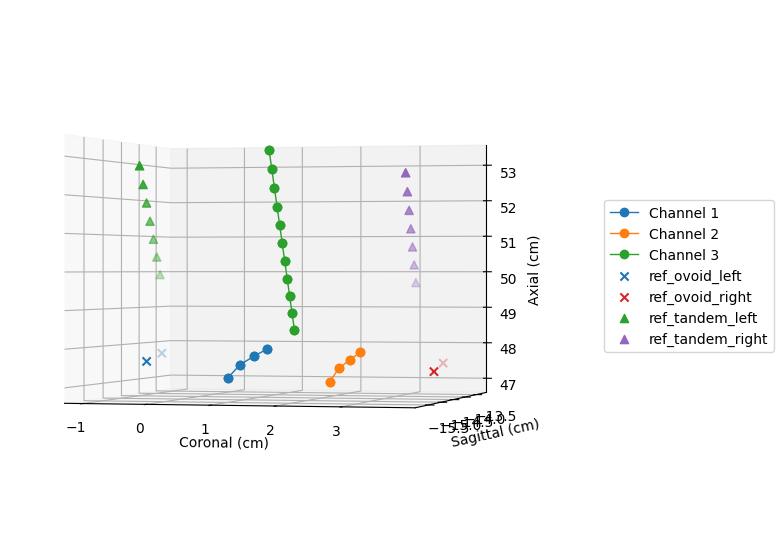

In [21]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

for channel in rt_channels:
    pts = [p for p in channel.positions_cm if p is not None]
    if not pts:
        continue
    arr = np.asarray(pts, dtype=float)
    ax.plot(arr[:, 0], arr[:, 1], arr[:, 2], marker='o', linewidth=1.0, label=f"Channel {channel.channel_number}")

markers = {
    'ref_ovoid_left': ('x', '#1f77b4'),
    'ref_ovoid_right': ('x', '#d62728'),
    'ref_tandem_left': ('^', '#2ca02c'),
    'ref_tandem_right': ('^', '#9467bd'),
}
for label, pts in reference_sets.items():
    pts = np.asarray(pts, dtype=float)
    if pts.size == 0:
        continue
    marker, color = markers.get(label, ('x', 'black'))
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=35, marker=marker, color=color, label=label)

ax.set_xlabel('Coronal (cm)')
ax.set_ylabel('Sagittal (cm)')
ax.set_zlabel('Axial (cm)')
ax.view_init(elev=0, azim=-75, roll=0)
ax.legend(bbox_to_anchor=(1.1, 0.5), loc='center left')
plt.tight_layout()
plt.show()

In [22]:
tables = dosecal.load_nucletron_tg43_tables(
    cfg["hyperparams"]["anisotropy_table"],
    cfg["hyperparams"]["radial_table"],
)
dwells, _ = dosecal.dwells_from_records(rt_channels)
channel_map = dataloader.map_channel_dwell_indices(rt_channels, dwells)
required_channels = ("ovoid_left", "ovoid_right", "tandem")
if len(channel_map) < len(required_channels):
    raise ValueError("Not enough channels found for T&O optimisation.")

dwell_indices: List[int] = []
dwell_records: List[Dict[str, Any]] = []
for channel_idx, label in enumerate(required_channels):
    indices = channel_map[channel_idx]
    channel = rt_channels[channel_idx]
    for local_idx, dwell_idx in enumerate(indices):
        dwell_indices.append(dwell_idx)
        dwell_records.append({
            "channel_label": label,
            "channel_number": channel.channel_number,
            "local_index": local_idx,
        })

opt_dwells = [dwells[i] for i in dwell_indices]
baseline_times = np.array([d.dwell_time_s for d in opt_dwells], dtype=float)
A_ref, target_doses_cgy, constraint_rows = build_reference_constraints(
    reference_sets, opt_dwells, tables, prescription_dose_cgy
)
print(f"Optimising {len(opt_dwells)} dwell positions with {A_ref.shape[0]} constraints")

Optimising 38 dwell positions with 18 constraints


In [23]:
delta = cp.Variable(baseline_times.shape[0])
updated_times = baseline_times + delta
constraints = [updated_times >= 0]
if A_ref.size:
    constraints.append(A_ref @ updated_times >= target_doses_cgy)
objective = cp.Minimize(cp.sum_squares(delta))
prob = cp.Problem(objective, constraints)
prob.solve(solver=cp.OSQP, warm_start=True)
print(f"Solver status: {prob.status}, objective: {prob.value:.4f}")
if prob.status not in ("optimal", "optimal_inaccurate"):
    raise RuntimeError("Convex optimisation failed to find a feasible solution.")
optimised_times = np.asarray(updated_times.value, dtype=float).ravel()

Solver status: optimal, objective: 996.1647


In [24]:
dwell_summary = pd.DataFrame(dwell_records)
dwell_summary["plan_time_s"] = baseline_times
dwell_summary["optimised_time_s"] = optimised_times
dwell_summary["delta_s"] = dwell_summary["optimised_time_s"] - dwell_summary["plan_time_s"]
plan_vals = dwell_summary["plan_time_s"].to_numpy()
with np.errstate(divide="ignore", invalid="ignore"):
    percent = np.where(
        np.abs(plan_vals) > 1e-6,
        dwell_summary["delta_s"] / dwell_summary["plan_time_s"],
        np.nan,
    )
dwell_summary["percent_change"] = percent
dwell_summary

if A_ref.shape[0]:
    reference_report = pd.DataFrame(constraint_rows)
    reference_report["plan_dose_cgy"] = (A_ref @ baseline_times)
    reference_report["optimised_dose_cgy"] = (A_ref @ optimised_times)
    reference_report["slack_cgy"] = reference_report["optimised_dose_cgy"] - reference_report["target_dose_cgy"]
else:
    reference_report = pd.DataFrame(columns=[
        "group", "subset", "point_index", "point_cm", "target_dose_cgy",
        "plan_dose_cgy", "optimised_dose_cgy", "slack_cgy",
    ])
reference_report

,group,subset,point_index,point_cm,target_dose_cgy,plan_dose_cgy,optimised_dose_cgy,slack_cgy
0,ovoid,ref_ovoid_left,0,"[-0.9417683009584734, -13.924084526270855, 47....",840.0,427.634949,847.737129,7.737129e+00
1,ovoid,ref_ovoid_left,1,"[-0.9297637009584734, -14.387722326270856, 47....",840.0,419.930346,840.000000,1.136868e-13
2,ovoid,ref_ovoid_right,0,"[3.599154700958474, -13.601532773729147, 47.47...",840.0,431.052956,846.438411,6.438411e+00
3,ovoid,ref_ovoid_right,1,"[3.629671500958473, -14.063950773729147, 47.28...",840.0,423.961508,840.000000,0.000000e+00
4,tandem,ref_tandem_left,0,"[-0.22384743461129797, -15.782734568361137, 52...",600.0,489.318294,602.417572,2.417572e+00
5,tandem,ref_tandem_left,1,"[-0.2629895346112976, -15.621503268361138, 52....",600.0,533.975844,665.012324,6.501232e+01
6,tandem,ref_tandem_left,2,"[-0.3021315346112976, -15.460271968361138, 51....",600.0,562.747715,712.939607,1.129396e+02
7,tandem,ref_tandem_left,3,"[-0.3412735346112976, -15.299040668361137, 51....",600.0,579.201625,750.675499,1.506755e+02
8,tandem,ref_tandem_left,4,"[-0.3804155346112976, -15.137809368361138, 50....",600.0,587.052713,783.134342,1.831343e+02
9,tandem,ref_tandem_left,5,"[-0.41955753461129763, -14.976578168361137, 50...",600.0,588.832651,814.403972,2.144040e+02


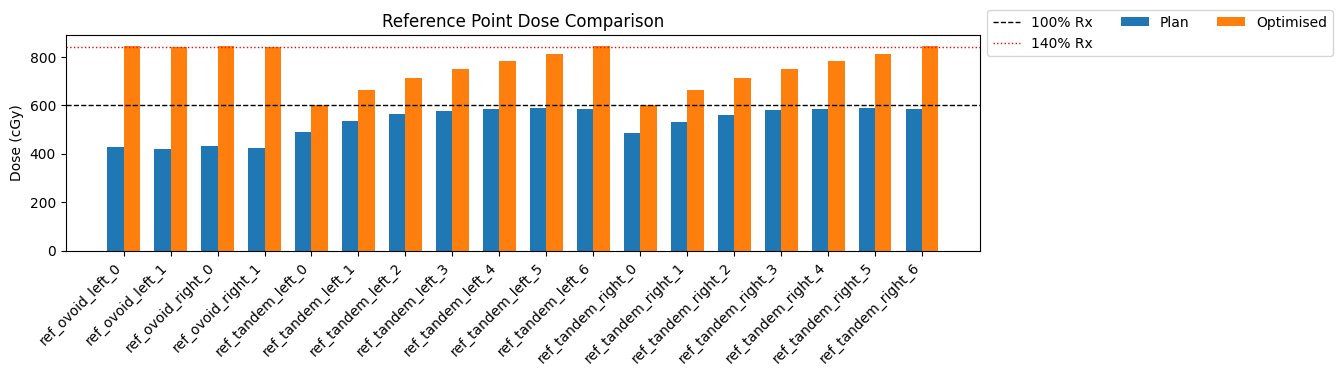

In [25]:
if reference_report.empty:
    print('No reference dose data available for plotting.')
else:
    df = reference_report.copy()
    df['label'] = df['subset'] + '_' + df['point_index'].astype(str)
    x = np.arange(len(df))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(x - width/2, df['plan_dose_cgy'], width, label='Plan')
    ax.bar(x + width/2, df['optimised_dose_cgy'], width, label='Optimised')
    ax.axhline(prescription_dose_cgy, color='k', linestyle='--', linewidth=1.0, label='100% Rx')
    ax.axhline(prescription_dose_cgy * 1.4, color='r', linestyle=':', linewidth=1.0, label='140% Rx')
    ax.set_xticks(x)
    ax.set_xticklabels(df['label'], rotation=45, ha='right')
    ax.set_ylabel('Dose (cGy)')
    ax.set_title('Reference Point Dose Comparison')
    ax.legend(ncol=3, bbox_to_anchor=(1.0, 1.15))
    plt.tight_layout()
    plt.show()